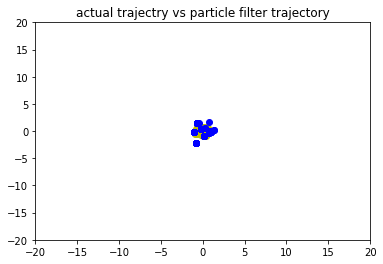

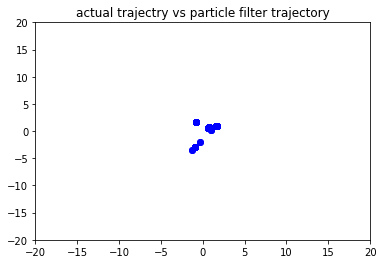

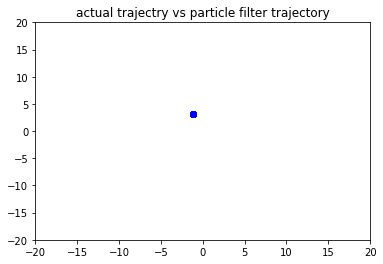

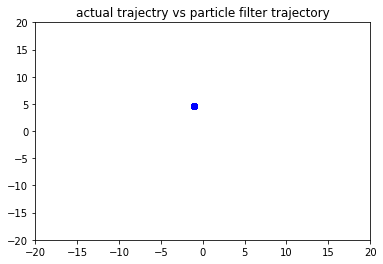

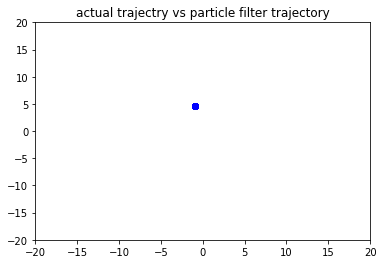

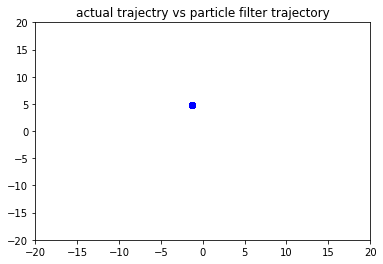

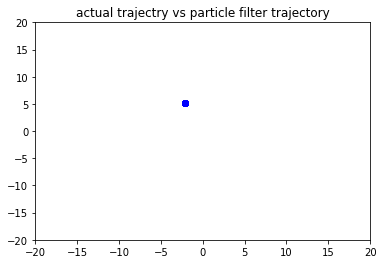

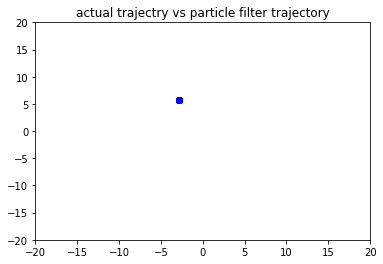

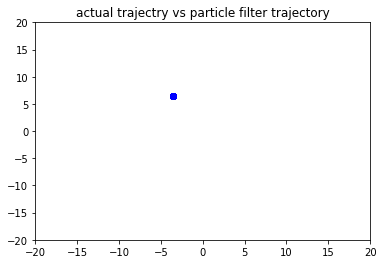

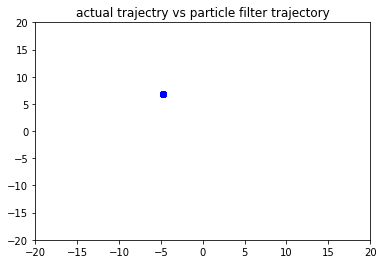

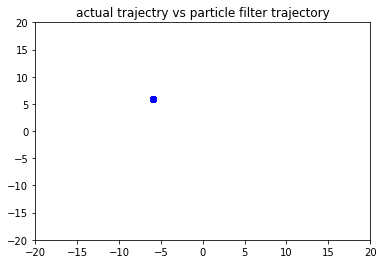

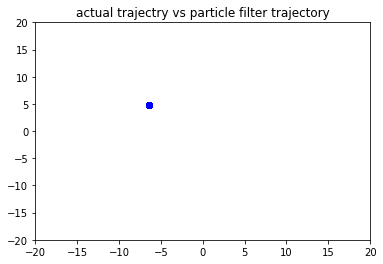

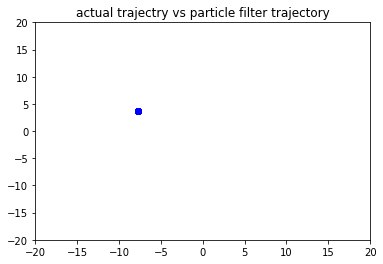

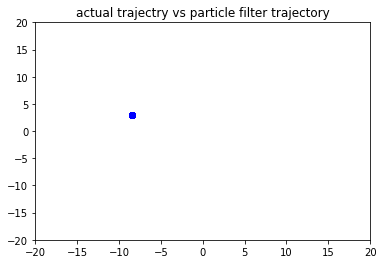

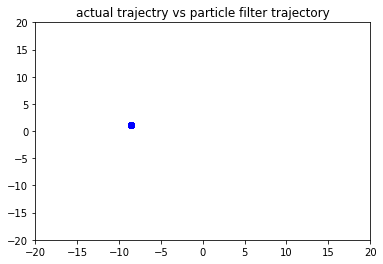

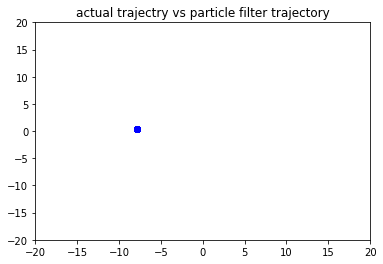

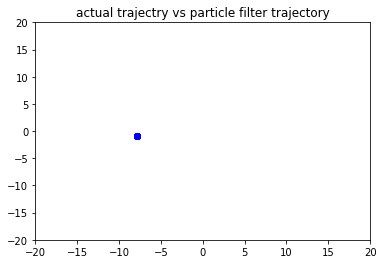

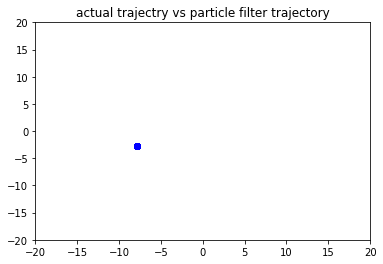

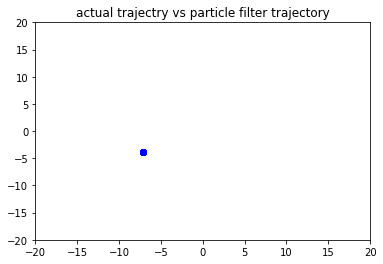

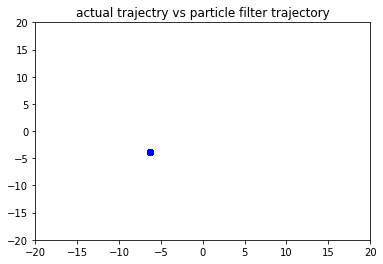

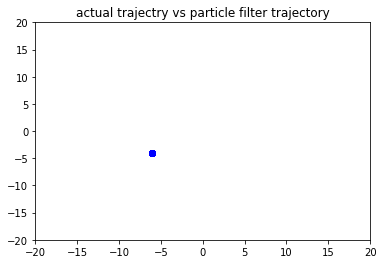

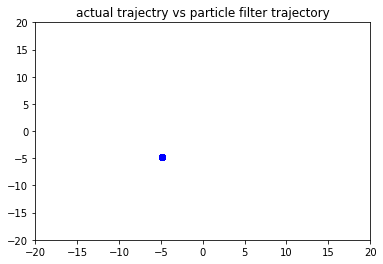

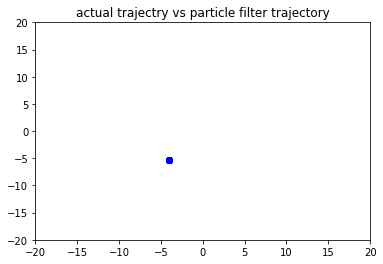

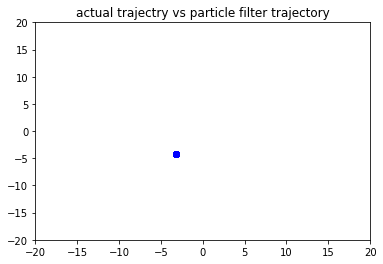

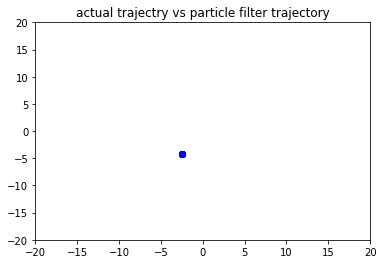

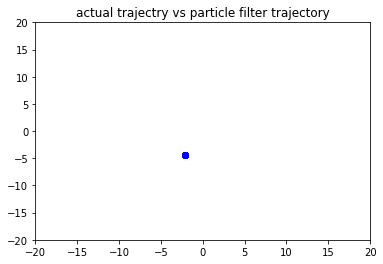

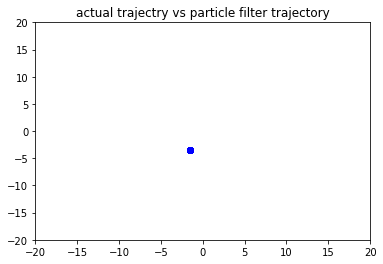

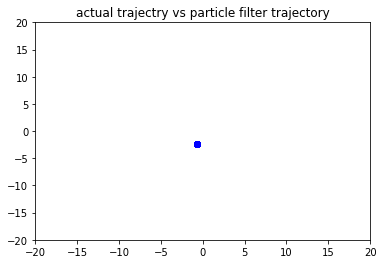

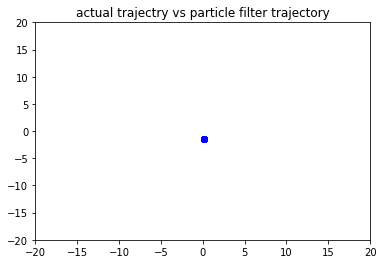

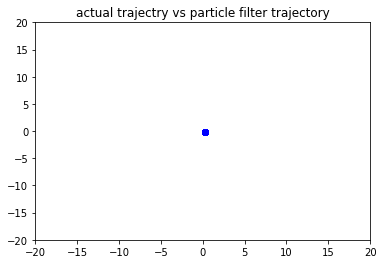

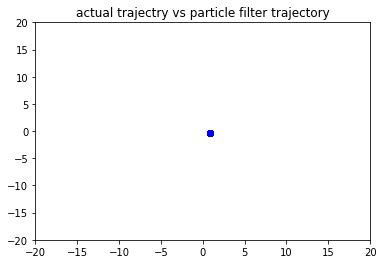

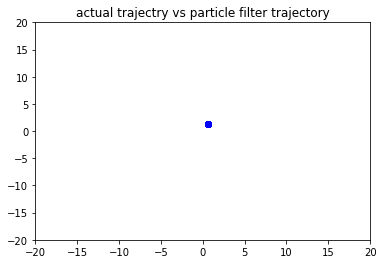

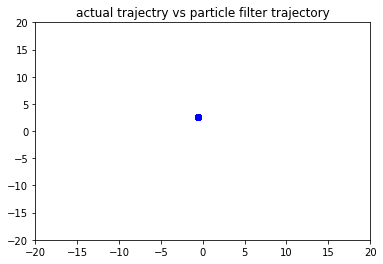

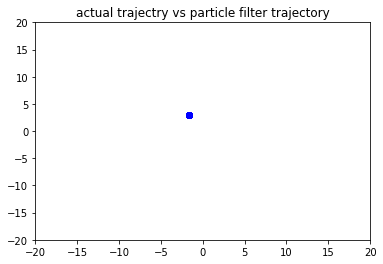

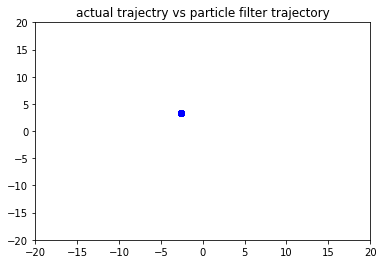

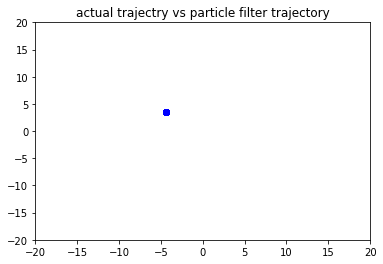

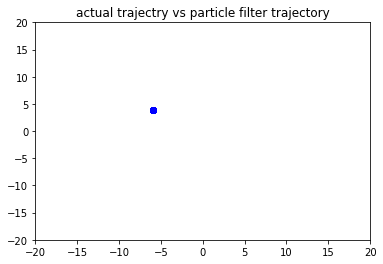

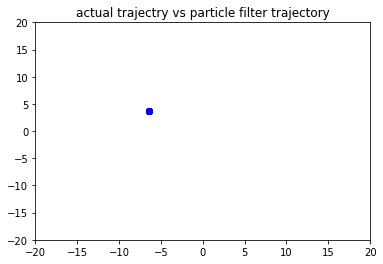

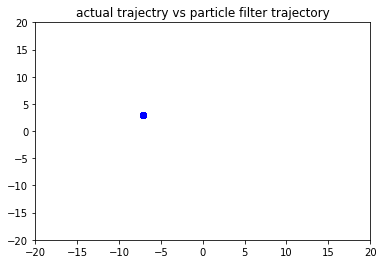

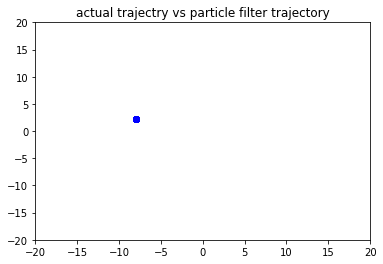

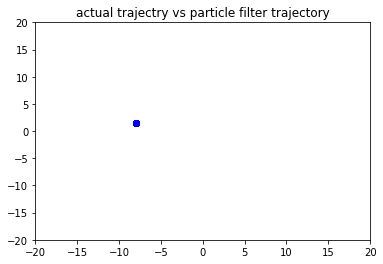

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [4]:
#.........................inspired from lecture notes + https://www.youtube.com/watch?v=MsYlueVDLI0&t=478s + Particle filter tutorial :https://www.youtube.com/watch?v=HZvF8KlFoWk




import numpy as np
import matplotlib.pyplot as plt
import math
import random
    
def pdfgen(pmf = None): 
    #This function generates a random sample from the density function pmf
    
    N = len(pmf)
    F = np.zeros((1,N))
    F[0,0] = pmf[0]
    #generate the distribution function
    for k in range(1,N):
        F[0,k] = F[0,k - 1] + pmf[k]
    
    b = np.array(random.uniform(0, 1))
    ind = np.where(F >= b)
    out = ind[1][1]
    return out


#.....................................Information provided.................................

#Covariance matrix
sigma_initial = np.zeros((3,3))
sigma_initial[0,0] = 0.1
sigma_initial[1,1] = 0.1
sigma_initial[2,2] = math.pi


sigma_x = 0.5
sigma_y = 0.5
sigma_theta = 0.1
R = np.array([[sigma_x,0,0],[0,sigma_y,0],[0,0,sigma_theta]])

#control signals
u1 = 1
u2 = 0.2

#Implementation without noise
x0 = 0
y0 = 0
theta_0 = 0
time_period = 500

#No noise  in initial estimate
u_initial = np.array([0,0,0])

# initial actual pose
pose = np.zeros((3,time_period))
pose[0,0] = x0
pose[1,0] = y0
pose[2,0] = theta_0

#no of particles
particles = 500

#............................Setting up equations.........................................

#set of particles array size
X = np.zeros((3,particles,time_period))

#set of particles beleif size
X_ = np.zeros((3,particles,time_period))

#set of weights
weights = np.ones((particles,time_period))

#initial particle distribution which is distributed around Multivariate normal distribution 

particles_distribution = np.random.multivariate_normal(u_initial,sigma_initial,particles)

#assigning the values to the particle set
X[:,:,0] = np.transpose(particles_distribution)
X_[:,:,0] = X[:,:,0]



#Measurement vector
z = np.zeros((3,time_period))
z[0,0] = pose[0,0]
z[1,0] = pose[1,0]
z[2,0] = pose[2,0]


#Measurement Vector as provided in the book
C = np.array([[1,0,0],[0,1,0],[0,0,1]])
Q = np.array([[0.5,0,0],[0,0.2,0],[0,0,0.1]])

mu = 0


#figures based on inital particle distribution
plt.figure(1)
plt.scatter(X[0,:,0],X[1,:,0],c='y')

for i in range(1,time_period):
    
    
    #update pose 
    pose[0,i] = pose[0,i - 1] + u1 * np.cos(pose[2,i - 1]) + np.random.normal(0,sigma_x)
    pose[1,i] = pose[1,i - 1] + u1 * np.sin(pose[2,i - 1]) + np.random.normal(0,sigma_y)
    pose[2,i] = pose[2,i - 1] + u2 + np.random.normal(0,sigma_theta)
    
    
    #Actual Measurement is updated
    z[0,i] = pose[0,i] + np.random.normal(pose[0,i],Q[0,0])
    z[1,i] = pose[1,i] + np.random.normal(pose[1,i],Q[1,1])
    z[2,i] = pose[2,i] + np.random.normal(pose[2,i],Q[2,2])
    
    
    #..........................................Particle filter..............................................
    #Prediction setp
    
    for j in range(1,time_period):
        X_[0,j,i] = X[0,j,i - 1] + u1 * np.cos(X[2,j,i - 1]) + np.random.normal(mu,sigma_x)
        X_[1,j,i] = X[1,j,i - 1] + u1 * np.sin(X[2,j,i - 1]) + np.random.normal(mu,sigma_y)
        X_[2,j,i] = X[2,j,i - 1] + u2 + np.random.normal(mu,sigma_theta)
        #angle in radians
        X_[2,j,i] = math.atan2(np.sin(X_[2,j,i]),np.cos(X_[2,j,i]))
        
        
        
        
        
        #updating weight

        ayao = (1 / np.sqrt(np.linalg.det(2 * math.pi * Q)))
        wa = z[:,i].reshape(-1,1) - np.matmul(C,X_[:,i,i].reshape(-1,1))
        wb = np.linalg.inv(Q)
        wc= -0.5* np.transpose(z[:,i].reshape(-1,1) - np.matmul(C,X_[:,j,i].reshape(-1,1)))
        wd = np.matmul(wb,wa)
        we = np.matmul(wc,wd)
        wf = np.exp(we)

        weights[j,i] =  ayao*wf
    
        

    #normalization of weight update matrix which gives the distribution
    weights[:,i] = (weights[:,i] / sum(weights[:,i]))

    
    
    
    
    #Resampling with the help of pdfgen, and storing into particle set
    for k in range((particles)):
        result_index = pdfgen(weights[:,i].reshape(-1,1))
        temp_col = (X_[:,result_index,i].reshape(-1,1))
        X[:,k,[i]] = temp_col.reshape(-1,1)
    plt.figure(1)
    plt.scatter(X[0,:,i],X[1,:,i],c='b')
    plt.axis(np.array([- 20,20,- 20,20]))
    plt.title('actual trajectry vs particle filter trajectory')
    plt.draw()
    plt.pause(0.0001)
    plt.clf()



In [ ]:
j